In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import random

device = torch.device("cpu")
print("Używane urządzenie:", device)


Używane urządzenie: cpu


In [2]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder('data/train', transform=transform)
val_dataset = datasets.ImageFolder('data/val', transform=transform)
test_dataset = datasets.ImageFolder('data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

emotion_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}
print("Label map:", emotion_labels)


Label map: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}


In [13]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = EmotionCNN(num_classes=7).to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

def evaluate(loader, model):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return val_loss / total, correct / total

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = evaluate(val_loader, model)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Time: {time.time()-start:.2f}s")


Epoch 1/10 | Train Loss: 1.5581 | Val Loss: 1.4271 | Val Acc: 44.66% | Time: 48.70s
Epoch 2/10 | Train Loss: 1.3217 | Val Loss: 1.3251 | Val Acc: 48.01% | Time: 37.94s
Epoch 3/10 | Train Loss: 1.1857 | Val Loss: 1.2625 | Val Acc: 51.80% | Time: 39.41s
Epoch 4/10 | Train Loss: 1.0624 | Val Loss: 1.3222 | Val Acc: 50.35% | Time: 40.31s
Epoch 5/10 | Train Loss: 0.9268 | Val Loss: 1.2685 | Val Acc: 53.08% | Time: 40.39s
Epoch 6/10 | Train Loss: 0.7830 | Val Loss: 1.3461 | Val Acc: 53.33% | Time: 40.12s
Epoch 7/10 | Train Loss: 0.6337 | Val Loss: 1.4772 | Val Acc: 52.61% | Time: 40.65s
Epoch 8/10 | Train Loss: 0.4911 | Val Loss: 1.7616 | Val Acc: 53.02% | Time: 40.57s
Epoch 9/10 | Train Loss: 0.3561 | Val Loss: 1.9017 | Val Acc: 54.36% | Time: 40.23s
Epoch 10/10 | Train Loss: 0.2555 | Val Loss: 2.2953 | Val Acc: 52.22% | Time: 40.38s


In [15]:
test_loss, test_acc = evaluate(test_loader, model)
print(f"\n🎯 Test Accuracy: {test_acc * 100:.2f}%")



🎯 Test Accuracy: 54.86%


Znaleziono tylko 21 obrazów, zamiast 25.


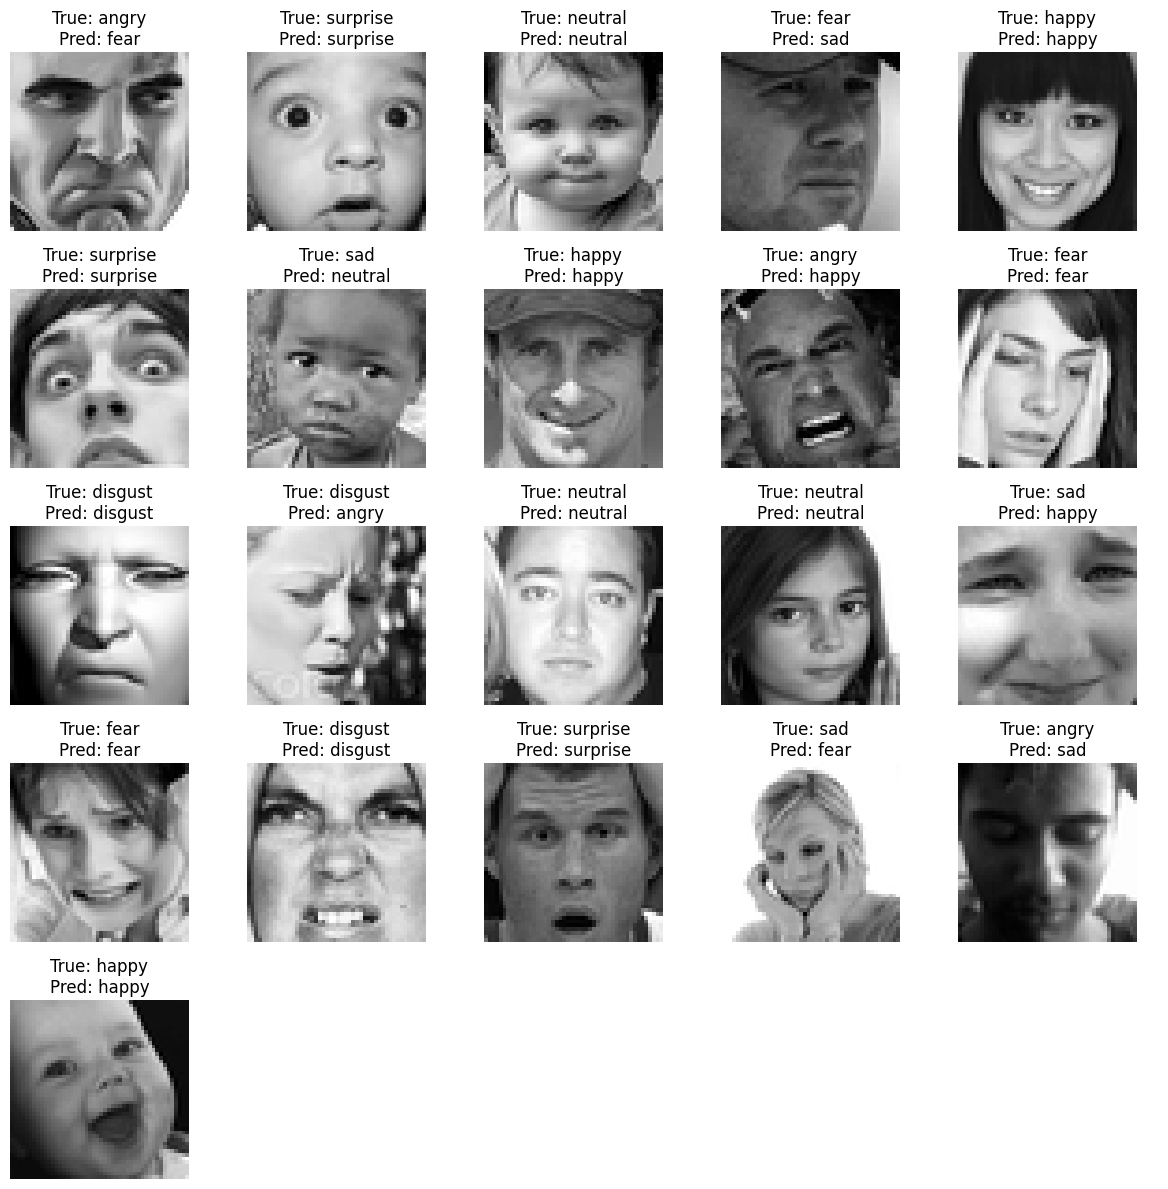

In [ ]:
def visualize_predictions(model, dataloader, label_map, num_images=25):
    model.eval()
    
    images_list = []
    labels_list = []

    class_images = {class_id: [] for class_id in range(len(label_map))}
    
    # Zbieramy obrazy z różnych klas
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        for i in range(len(labels)):
            class_images[labels[i].item()].append(images[i].cpu())
        
        # Sprawdzamy, czy mamy już odpowiednią ilość obrazów z różnych klas
        if all(len(class_images[class_id]) >= num_images // len(label_map) for class_id in range(len(label_map))):
            break

    selected_images = []
    selected_labels = []

    # Wystarczająca liczbę obrazów z każdej klasy
    for class_id, images in class_images.items():
        if len(images) >= num_images // len(label_map):
            selected_images.extend(random.sample(images, num_images // len(label_map)))
            selected_labels.extend([class_id] * (num_images // len(label_map)))

    # Jeżeli nie, dostosuj 'num_images'
    total_images = len(selected_images)
    if total_images < num_images:
        num_images = total_images 

    # Losowo permutujemy obrazy i etykiety
    indices = torch.randperm(len(selected_images)).tolist()
    selected_images = [selected_images[i] for i in indices]
    selected_labels = [selected_labels[i] for i in indices]

    rows = (num_images + 4) // 5 
    cols = min(num_images, 5) 

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    with torch.no_grad():
        inputs = torch.stack(selected_images).to(device)
        labels_tensor = torch.tensor(selected_labels).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # Zabezpieczenie przed przekroczeniem zakresu
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(selected_images[i].squeeze(), cmap='gray')
        ax.set_title(f"True: {label_map[labels_tensor[i].item()]}\nPred: {label_map[predicted[i].item()]}")
        ax.axis('off')

    #puste osie
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, emotion_labels)